# ROMY - Barometric Models

In [20]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis

### Configurations

In [21]:
station = "DROMY" # "FUR" or "ROMY" or "DROMY"

# date = "20240315"
# date = "20240324"
# date = "20240423"
date = "20240312"


# select channel A = tilt, J = rotation rate, H = acceleration
cha ="*A*"

# load config
config = baroseis.load_from_yaml(f"./data/config_FFBI_{station}_{date}_file.yaml")


FileNotFoundError: Configuration file ./data/config_FFBI_DROMY_20240312_file.yaml not found

### Load Spatial Pressure Gradients

In [ ]:
gradient = obs.read(f"./data/pressure_gradient_{date}.mseed")

gradient = gradient.trim(config['tbeg'], config['tend'])
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient

2 Trace(s) in Stream:
BW.PROMY.01.LDN | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples
BW.PROMY.01.LDE | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples

In [ ]:
# Initialize baroseis object
bs = baroseis(conf=config)

# Load data specified in config
bs.load_data()

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes



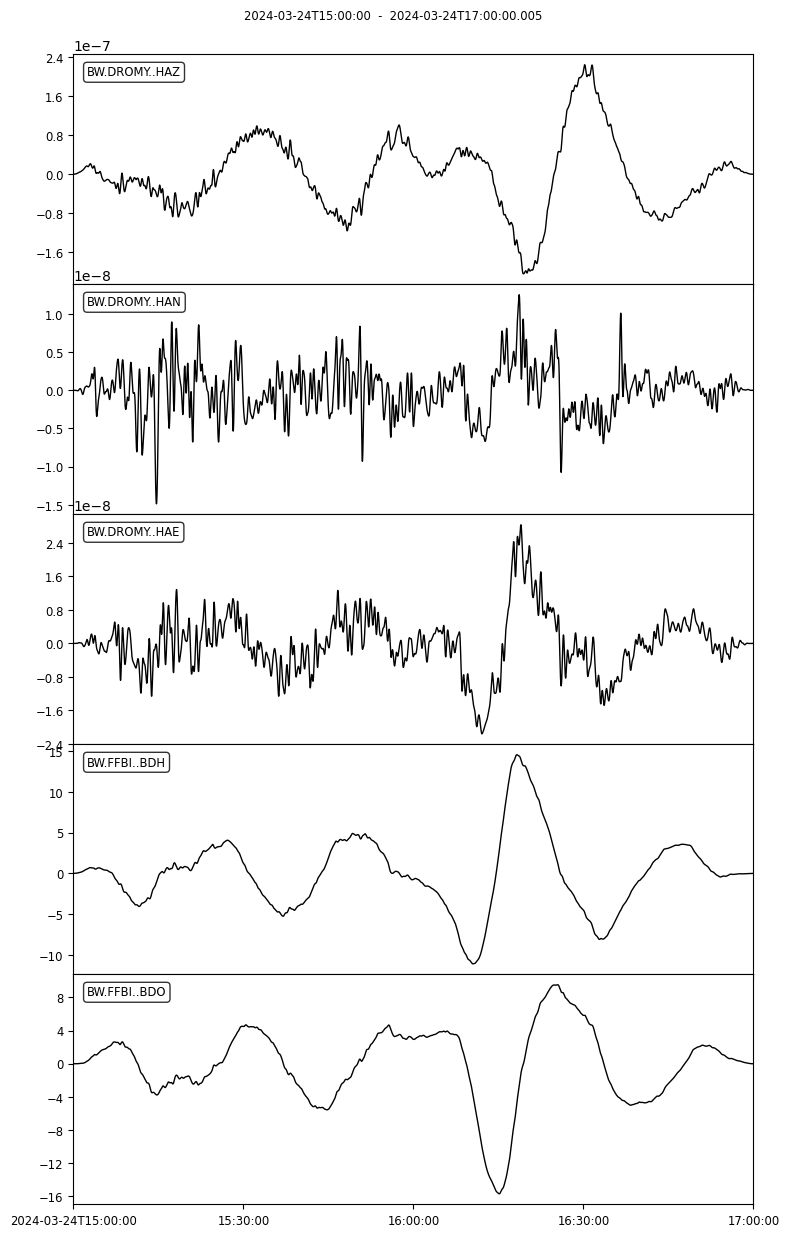

In [22]:
bs.st.plot(equal_scale=False);

Removing mean and trend...
Applying bandpass filter: 0.0005-0.03 Hz


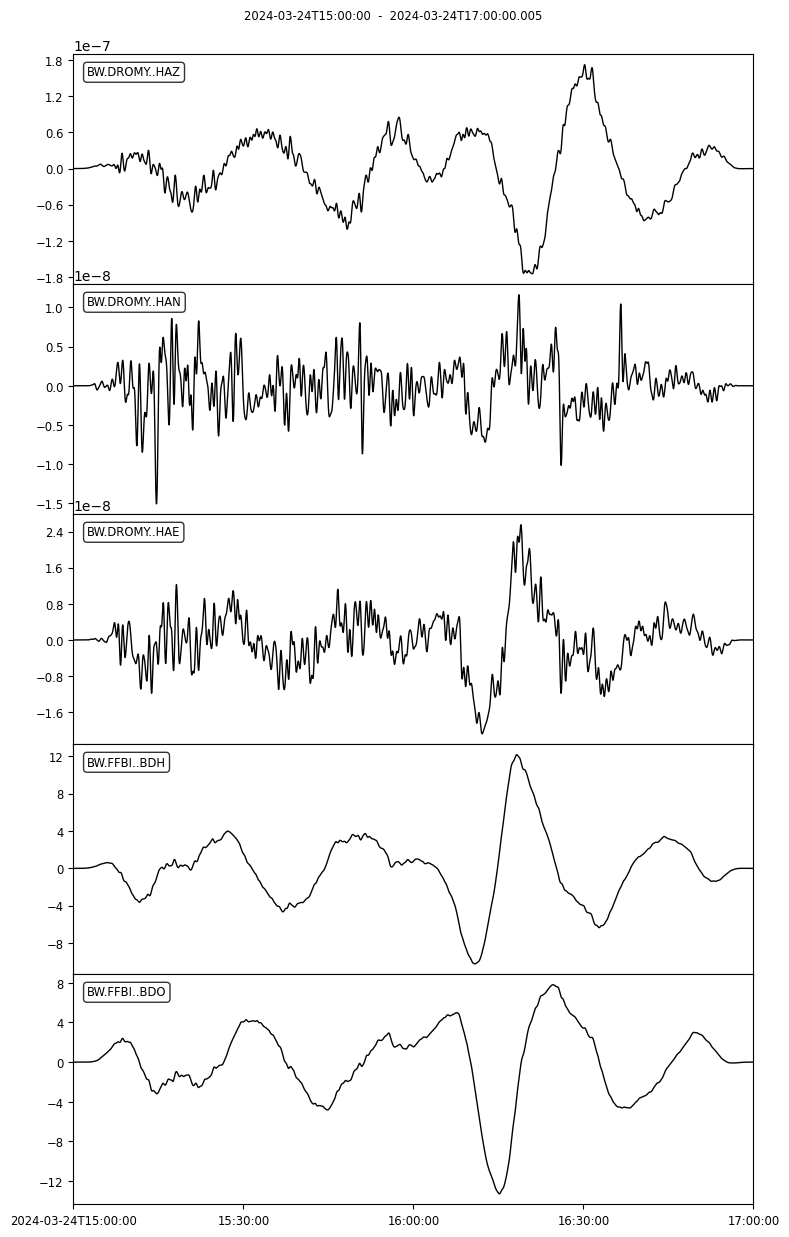

In [23]:
# band pass filer
bs.filter_data(fmin=0.0005, fmax=0.03)

# detrend
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.1, "cosine")

if station == "ROMY":
    # integrate rotation to tilt
    bs.integrate_data(method="cumtrapz") # method = "cumtrapz" or "spline"

elif station == "FUR" or station == "DROMY":
    # convert acceleration to tilt
    for tr in bs.st:
        if tr.stats.channel[1] == "H":
            tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]
            if tr.stats.channel[-1] in ["N", "E"]:
                tr.data = -tr.data/9.81
    
# trim waveforms
bs.st = bs.st.trim(bs.config['tbeg'], bs.config['tend'])

# detrend waveforms
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.05, "cosine")

# show new waveforms
bs.st.plot(equal_scale=False);


In [24]:
def model_tilt(seis_stream, pressure_data):
    """
    Simple model for predicting tilt/rotation from pressure data.
    
    Args:
        seis_stream: Stream with seismic data
        pressure_data: List of pressure arrays [P, H, DP, DH]
    
    Returns:
        Dictionary with predicted_data, coefficients, variance_reduction, residuals
    """
    
    # Get seismic data
    components = ['N', 'E', 'Z']
    seis_data = {}
    
    for comp in components:
        try:
            tr = seis_stream.select(component=comp).copy()[0]
            seis_data[comp] = tr.data
        except:
            continue
    
    if not seis_data:
        raise ValueError("No seismic data found")
    
    # Ensure all data has same length
    data_length = len(pressure_data[0])
    for comp in seis_data:
        if len(seis_data[comp]) != data_length:
            # Simple interpolation
            from scipy.interpolate import interp1d
            x_old = np.linspace(0, 1, len(seis_data[comp]))
            x_new = np.linspace(0, 1, data_length)
            f = interp1d(x_old, seis_data[comp], kind='linear', fill_value='extrapolate')
            seis_data[comp] = f(x_new)
    
    # Create design matrix
    A = np.column_stack(pressure_data)
    
    # Results
    results = {
        'predicted_data': {},
        'coefficients': {},
        'variance_reduction': {},
        'residuals': {}
    }
    
    # Process each component
    for comp, seis_comp_data in seis_data.items():
        # Least squares: A * x = b
        coefficients = np.linalg.lstsq(A, seis_comp_data, rcond=None)[0]
        predicted_data = A @ coefficients
        
        # Variance reduction
        original_var = np.var(seis_comp_data)
        residual_var = np.var(seis_comp_data - predicted_data)
        var_reduction = ((original_var - residual_var) / original_var) * 100
        
        # Store
        results['predicted_data'][comp] = predicted_data
        results['coefficients'][comp] = coefficients
        results['variance_reduction'][comp] = var_reduction
        results['residuals'][comp] = seis_comp_data - predicted_data
    
    return results

### Model 1

In [25]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
]

# Run model
model1 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model1['predicted_data']:
    print(f"{comp}: {model1['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 19.2%
E: 73.6%
Z: 57.0%


### Model 2

In [26]:
seis_stream = bs.st.select(channel=cha).copy()
pressure_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    bs.st.select(channel="*DO").copy().differentiate()[0].data,
    bs.st.select(channel="*DH").copy().differentiate()[0].data
]

# Run model
model2 = model_tilt(seis_stream, pressure_data)

# Access results
print("Variance reduction:")
for comp in model2['predicted_data']:
    print(f"{comp}: {model2['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 28.6%
E: 87.1%
Z: 62.5%


### Model 3

In [27]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    gradient.select(channel="*DE")[0].data,
    gradient.select(channel="*DN")[0].data,
]

# Run model
model3 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model3['predicted_data']:
    print(f"{comp}: {model3['variance_reduction'][comp]:.1f}%")

# Get predicted data
predicted_data = model3['predicted_data']
coefficients = model3['coefficients']
print(coefficients)

Variance reduction:
N: 19.8%
E: 74.3%
Z: 58.3%
{'N': array([-3.88963734e-11,  3.72162302e-10, -1.43662147e-08, -1.11147566e-08]), 'E': array([ 4.56876729e-10,  1.43557879e-09, -3.78008640e-08, -2.76906527e-08]), 'Z': array([ 4.74165949e-09, -1.23963631e-08,  5.87004217e-07,  3.55977324e-07])}


### Model 4

In [28]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    gradient.select(channel="*DE")[0].data,
    gradient.select(channel="*DN")[0].data,
    gradient.select(channel="*DE").copy().differentiate()[0].data,
    gradient.select(channel="*DN").copy().differentiate()[0].data,
]

# Run model
model4 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model4['predicted_data']:
    print(f"{comp}: {model4['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 20.0%
E: 74.7%
Z: 61.8%


In [29]:
def plot_vr_comparison(model_list, figsize=(8, 5)):
    """
    Simple variance reduction comparison plot for a list of models.
    
    Args:
        model_list: List of dictionaries, each with 'name' and 'variance_reduction' keys
        figsize: Figure size tuple
    
    Example:
        models = [
            {'name': 'Basic', 'variance_reduction': {'N': 45, 'E': 38, 'Z': 52}},
            {'name': 'With Derivatives', 'variance_reduction': {'N': 67, 'E': 61, 'Z': 73}},
            {'name': 'Advanced', 'variance_reduction': {'N': 72, 'E': 69, 'Z': 79}}
        ]
        plot_vr_comparison(models)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    components = ['N', 'E', 'Z']
    x = np.arange(len(components))
    width = 0.8 / len(model_list)
    
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, model in enumerate(model_list):
        vr_values = [model['variance_reduction'].get(comp, 0) for comp in components]
        ax.bar(x + i * width, vr_values, width, 
               label=model['name'], color=colors[i % len(colors)], alpha=0.8)
        
    ax.set_ylabel('Variance Reduction (%)')
    ax.set_title('Variance Reduction Comparison')
    ax.set_xticks(x + width * (len(model_list) - 1) / 2)
    ax.set_xticklabels(f"{comp}-component" for comp in components)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    return fig

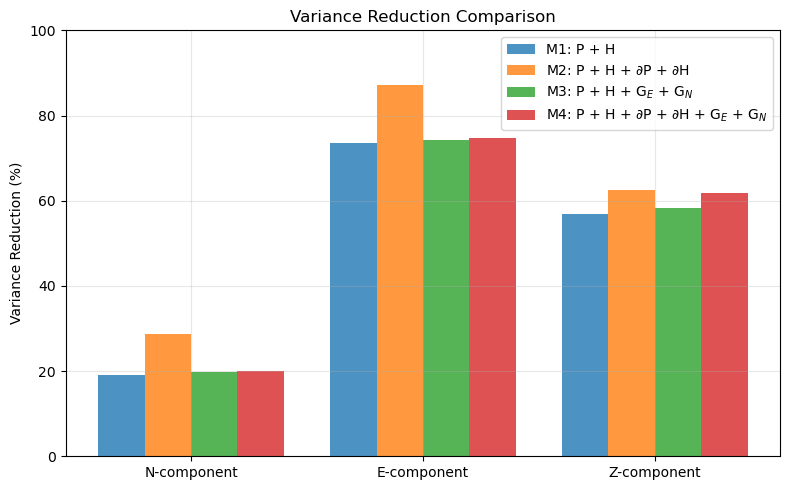

In [30]:
# Define your models
models = [
    {'name': r'M1: P + H', 'variance_reduction': model1['variance_reduction']},
    {'name': r'M2: P + H + $\partial$P + $\partial$H', 'variance_reduction': model2['variance_reduction']},
    {'name': r'M3: P + H + G$_E$ + G$_N$', 'variance_reduction':model3['variance_reduction']},
    {'name': r'M4: P + H + $\partial$P + $\partial$H + G$_E$ + G$_N$', 'variance_reduction':model4['variance_reduction']}
]

# Plot
fig = plot_vr_comparison(models)

fig.savefig(f"./figures/model_comparison/{date}_{station}_{cha}_model_vr_comparison.png", dpi=150, bbox_inches="tight")

In [31]:
def plot_waveform_comparison(seis_stream, model_results,
                           time_unit='minutes', residual=False, figsize=(15, 10)):
    """
    Simple plot with 3 vertical subplots (Z, N, E) showing waveforms for each model.
    
    Args:
        seis_stream: Original seismic stream
        model_results: Dictionary with model names as keys and results as values
        time_unit: Time unit for x-axis
        residual: Boolean to plot residuals
        figsize: Figure size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get time scaling
    tscale_dict = {"hours": 1/3600, "days": 1/86400, "minutes": 1/60, "seconds": 1}
    tscale = tscale_dict.get(time_unit, 1/60)
    
    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            times = orig_tr.times() * tscale
            orig_data = orig_tr.data * yscale
            
            # Plot original data
            axes[i].plot(times, orig_data, 'k-', linewidth=2, 
                        label=f'{comp}-Component', alpha=1, zorder=1)
            max_orig = np.max(np.abs(orig_data))

            # Plot each model
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    pred_data = results['predicted_data'][comp] * yscale
                    var_reduction = results['variance_reduction'][comp]
                    
                    color = colors[j % len(colors)]
                    if residual:
                        res_data = orig_data - pred_data
                        axes[i].plot(times, res_data, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(res_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
                    else:
                        axes[i].plot(times, pred_data, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(pred_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
            # Format subplot
            axes[i].set_ylabel(f"{ylabel}", fontsize=font)
            axes[i].legend(fontsize=font-2, ncol=2)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    # Set overall title
    if residual:
        title = f"Residual Comparison"
    else:
        title = f"Model Comparison"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

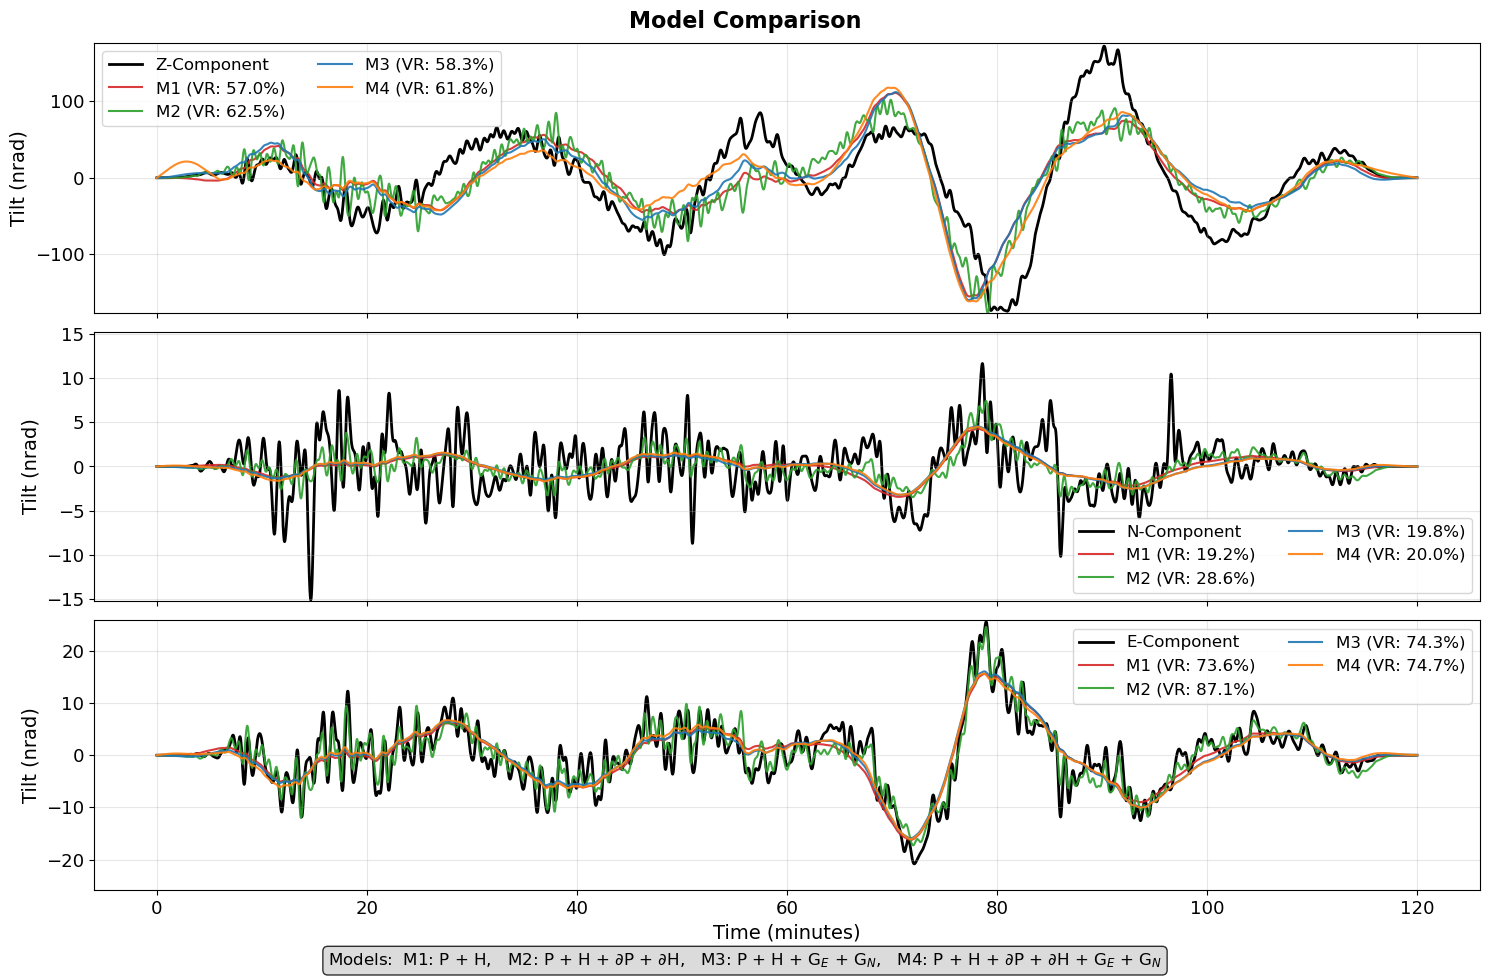

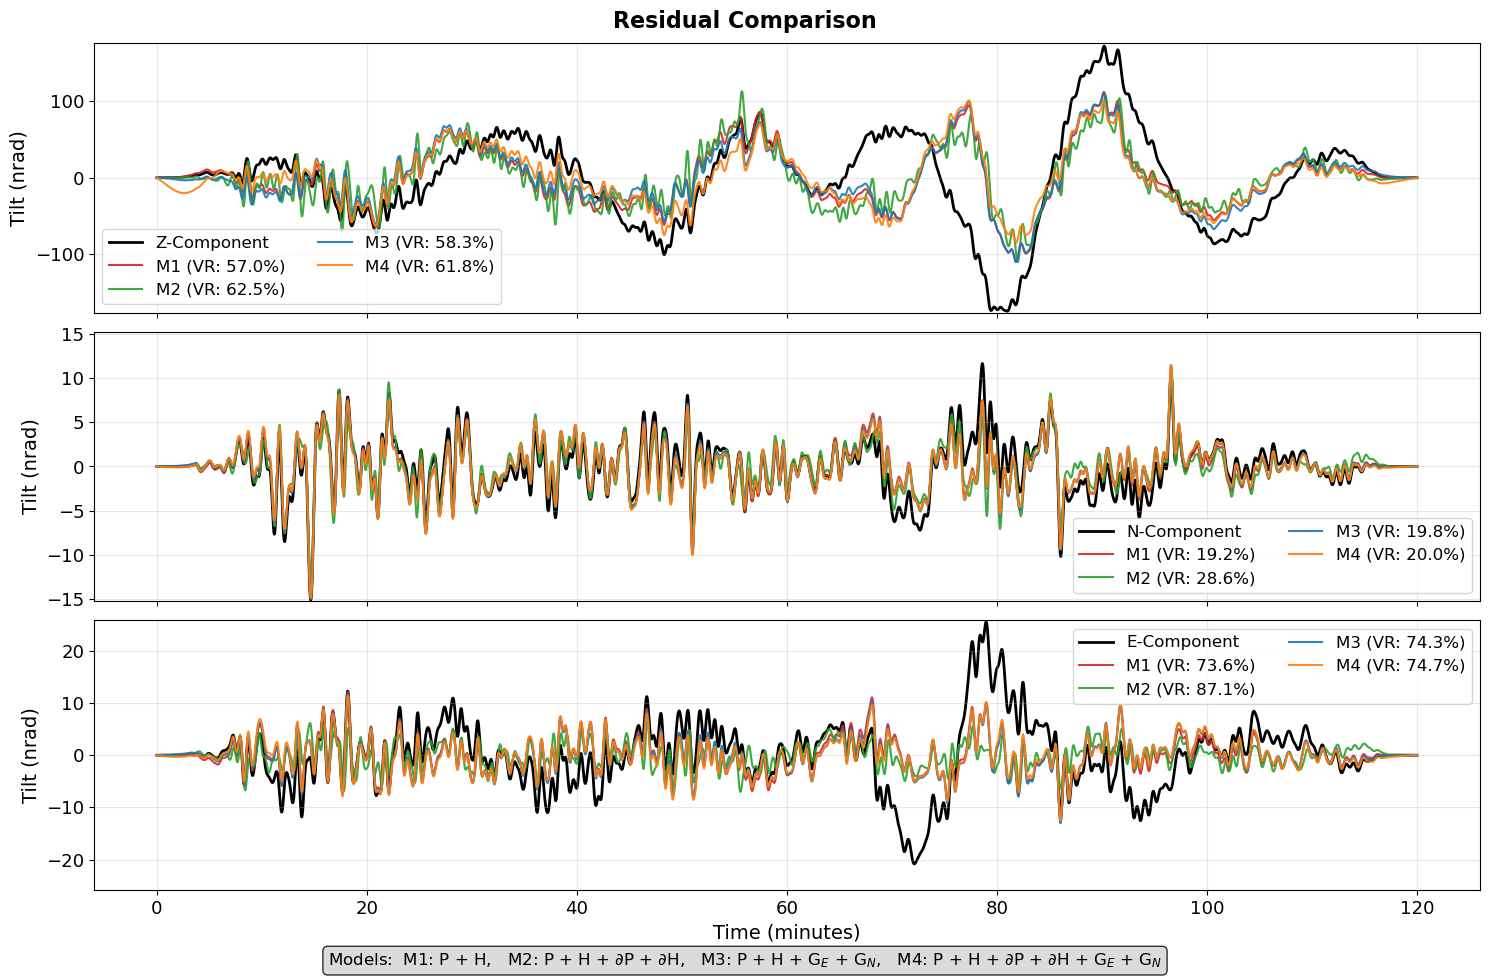

In [32]:

# Example usage:
model_results = {
    r'M1: P + H': model1,
    r'M2: P + H + $\partial$P + $\partial$H': model2,
    r'M3: P + H + G$_E$ + G$_N$': model3,
    r'M4: P + H + $\partial$P + $\partial$H + G$_E$ + G$_N$': model4
}

fig = plot_waveform_comparison(seis_stream, model_results)

fig.savefig(f"./figures/model_comparison/{date}_{station}_{cha}_model_waveform_comparison.png", dpi=150, bbox_inches="tight")

fig = plot_waveform_comparison(seis_stream, model_results, residual=True)

fig.savefig(f"./figures/model_comparison/{date}_{station}_{cha}_model_waveform_residual_comparison.png", dpi=150, bbox_inches="tight")


In [16]:
def plot_spectra_comparison(seis_stream, model_results,
                           method='welch', fmin=0.0005, fmax=0.03,
                           log_scale=True, db_scale=False, residual=False, 
                           smooth_octave=False, octave_fraction=1/3, 
                           smooth_method='median', figsize=(15, 10)):
    """
    Plot spectra comparison for 3 components (Z, N, E) showing spectra for each model.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import welch
    from scipy.fft import fft, fftfreq
    from scipy.signal import windows

    def smooth_octave_bands(freq, spectrum, octave_fraction=1/3, method='median'):
        """Smooth spectrum in fractional octave bands."""
        # Create octave band centers
        f_min = freq[freq > 0].min()
        f_max = freq.max()
        
        # Calculate number of octave bands
        n_octaves = int(np.log2(f_max / f_min) / octave_fraction) + 1
        
        # Create octave band centers
        f_centers = f_min * (2 ** (octave_fraction * np.arange(n_octaves)))
        
        # Calculate band edges
        f_lower = f_centers / (2 ** (octave_fraction / 2))
        f_upper = f_centers * (2 ** (octave_fraction / 2))
        
        # Initialize smoothed arrays
        freq_smooth = []
        spectrum_smooth = []
        
        for i in range(len(f_centers)):
            # Find frequencies within this octave band
            mask = (freq >= f_lower[i]) & (freq <= f_upper[i])
            
            if np.any(mask):
                if method == 'median':
                    smooth_val = np.median(spectrum[mask])
                else:  # mean
                    smooth_val = np.mean(spectrum[mask])
                
                freq_smooth.append(f_centers[i])
                spectrum_smooth.append(smooth_val)
        
        return np.array(freq_smooth), np.array(spectrum_smooth)

    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            
            # Compute original spectrum
            if method.lower() == 'fft':
                n = len(orig_tr.data)
                win = windows.hann(n)
                spec_orig = fft(orig_tr.data * win)
                freq = fftfreq(n, d=orig_tr.stats.delta)
                pos_freq = freq[0:n//2]
                mag_orig = np.abs(spec_orig[0:n//2]) * 2.0/n * yscale
            else:  # welch
                nperseg = int(orig_tr.stats.sampling_rate * 3600)  # 1-hour segments
                noverlap = nperseg // 2
                freq, psd_orig = welch(orig_tr.data, fs=orig_tr.stats.sampling_rate,
                                     window='hann', nperseg=nperseg, noverlap=noverlap)
                mag_orig = np.sqrt(psd_orig) * yscale
                pos_freq = freq
            
            # Apply octave band smoothing if requested
            if smooth_octave:
                pos_freq, mag_orig = smooth_octave_bands(pos_freq, mag_orig, 
                                                        octave_fraction, smooth_method)
            
            # Convert to dB if requested
            if db_scale:
                mag_orig = 20 * np.log10(mag_orig)
                ylabel_comp = ylabel + " (dB)"
            else:
                ylabel_comp = ylabel
            
            # Apply frequency limits
            mask = (pos_freq >= fmin) & (pos_freq <= fmax)
            pos_freq_plot = pos_freq[mask]
            mag_orig_plot = mag_orig[mask]
            
            # Plot original spectrum
            axes[i].plot(pos_freq_plot, mag_orig_plot, 'k-', linewidth=2, 
                        label=f'{comp}-Component', alpha=1, zorder=1)

            # Plot each model
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    residual_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
                    residual_tr.data = seis_stream.select(channel=f"*{comp}").copy()[0].data - results['predicted_data'][comp]
                    var_reduction = results['variance_reduction'][comp]
                    
                    # Compute predicted spectrum
                    if method.lower() == 'fft':
                        n = len(residual_tr.data)
                        win = windows.hann(n)
                        spec_pred = fft(residual_tr.data * win)
                        mag_pred = np.abs(spec_pred[0:n//2]) * 2.0/n * yscale
                        freq_pred = fftfreq(n, d=residual_tr.stats.delta)[0:n//2]
                    else:  # welch
                        nperseg = int(residual_tr.stats.sampling_rate * 3600)
                        noverlap = nperseg // 2
                        freq_pred, psd_pred = welch(residual_tr.data, fs=residual_tr.stats.sampling_rate,
                                                  window='hann', nperseg=nperseg, noverlap=noverlap)
                        mag_pred = np.sqrt(psd_pred) * yscale
                    
                    # Apply octave band smoothing if requested
                    if smooth_octave:
                        freq_pred, mag_pred = smooth_octave_bands(freq_pred, mag_pred, 
                                                                octave_fraction, smooth_method)
                    
                    # Convert to dB if requested
                    if db_scale:
                        mag_pred = 20 * np.log10(mag_pred)
                    
                    # Apply frequency limits
                    mask_pred = (freq_pred >= fmin) & (freq_pred <= fmax)
                    pos_freq_pred_plot = freq_pred[mask_pred]
                    mag_pred_plot = mag_pred[mask_pred]
                    
                    color = colors[j % len(colors)]
                    if residual:
                        # For residuals, we need to interpolate to match frequencies
                        from scipy.interpolate import interp1d
                        f_interp = interp1d(pos_freq_plot, mag_orig_plot, kind='linear', 
                                          bounds_error=False, fill_value=0)
                        mag_orig_interp = f_interp(pos_freq_pred_plot)
                        res_spectrum = mag_orig_interp - mag_pred_plot
                        axes[i].plot(pos_freq_pred_plot, res_spectrum, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                    else:
                        axes[i].plot(pos_freq_pred_plot, mag_pred_plot, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
            
            # Format subplot
            axes[i].set_ylabel(r"ASD nrad/$\sqrt{Hz}$", fontsize=font)
            axes[i].legend(loc='lower left', fontsize=font-2, ncol=2)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
            
            # Set scales
            if log_scale:
                axes[i].set_xscale('log')
                if not db_scale:  # Only use log scale for y-axis if not in dB
                    axes[i].set_yscale('log')
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    # Set overall title
    if residual:
        title = f"Spectra Residual Comparison"
    else:
        title = f"Spectra Model Comparison"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

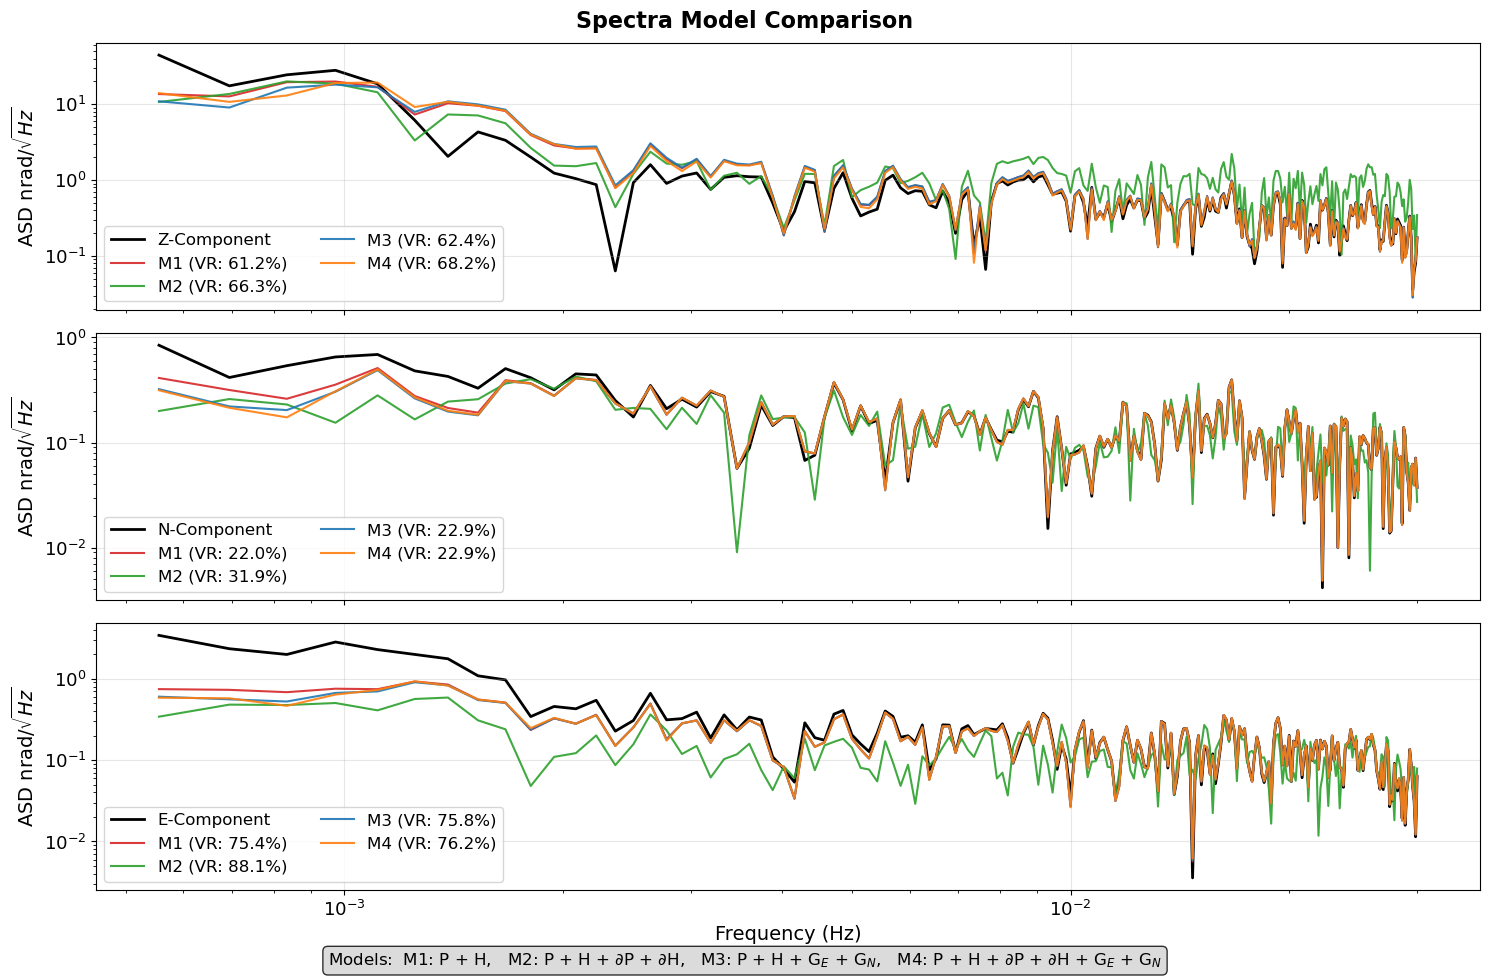

In [17]:
fig = plot_spectra_comparison(seis_stream, model_results, method='fft', db_scale=False)

# fig = plot_spectra_comparison(seis_stream, model_results, method='fft',
#                              smooth_octave=True, octave_fraction=1/6, smooth_method='median')

In [18]:
def plot_spectra_comparison(seis_stream, model_results, fmin=0.0005, fmax=0.03, 
                           smooth_octave=False, octave_fraction=1/3, smooth_method='median', 
                           figsize=(15, 10)):
    """
    Plot spectral difference comparison for 3 components (Z, N, E) showing difference of spectra in dB.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.fft import fft, fftfreq
    from scipy.signal import windows

    def smooth_octave_bands(freq, spectrum, octave_fraction=1/3, method='median'):
        """Smooth spectrum in fractional octave bands."""
        # Create octave band centers
        f_min = freq[freq > 0].min()
        f_max = freq.max()
        
        # Calculate number of octave bands
        n_octaves = int(np.log2(f_max / f_min) / octave_fraction) + 1
        
        # Create octave band centers
        f_centers = f_min * (2 ** (octave_fraction * np.arange(n_octaves)))
        
        # Calculate band edges
        f_lower = f_centers / (2 ** (octave_fraction / 2))
        f_upper = f_centers * (2 ** (octave_fraction / 2))
        
        # Initialize smoothed arrays
        freq_smooth = []
        spectrum_smooth = []
        
        for i in range(len(f_centers)):
            # Find frequencies within this octave band
            mask = (freq >= f_lower[i]) & (freq <= f_upper[i])
            
            if np.any(mask):
                if method == 'median':
                    smooth_val = np.median(spectrum[mask])
                else:  # mean
                    smooth_val = np.mean(spectrum[mask])
                
                freq_smooth.append(f_centers[i])
                spectrum_smooth.append(smooth_val)
        
        return np.array(freq_smooth), np.array(spectrum_smooth)

    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            
            # Compute original spectrum
            n = len(orig_tr.data)
            win = windows.hann(n)
            spec_orig = fft(orig_tr.data * win)
            freq = fftfreq(n, d=orig_tr.stats.delta)
            pos_freq = freq[0:n//2]
            mag_orig = np.abs(spec_orig[0:n//2]) * 2.0/n * yscale
            
            # Apply octave band smoothing to original spectrum if requested
            if smooth_octave:
                pos_freq, mag_orig = smooth_octave_bands(pos_freq, mag_orig, 
                                                        octave_fraction, smooth_method)
            
            # Plot each model spectral difference
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    residual_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
                    residual_tr.data = orig_tr.data - results['predicted_data'][comp]
                    var_reduction = results['variance_reduction'][comp]
                    
                    # Compute residual spectrum
                    spec_residual = fft(residual_tr.data * win)
                    mag_residual = np.abs(spec_residual[0:n//2]) * 2.0/n * yscale
                    freq_residual = freq[0:n//2]  # Use original frequency array
                    
                    # Apply octave band smoothing to residual spectrum if requested
                    if smooth_octave:
                        freq_residual, mag_residual = smooth_octave_bands(freq_residual, mag_residual, 
                                                                        octave_fraction, smooth_method)
                    
                    # For interpolation when smoothing is used
                    if smooth_octave:
                        from scipy.interpolate import interp1d
                        # Interpolate residual spectrum to match original frequency grid
                        f_interp = interp1d(freq_residual, mag_residual, kind='linear', 
                                          bounds_error=False, fill_value=0)
                        mag_residual_interp = f_interp(pos_freq)
                        
                        # Compute spectral difference using interpolated residual
                        mag_diff_db = 20 * np.log10(mag_residual_interp / mag_orig)
                        
                        # Apply frequency limits
                        mask = (pos_freq >= fmin) & (pos_freq <= fmax)
                        pos_freq_plot = pos_freq[mask]
                        mag_diff_plot = mag_diff_db[mask]
                    else:
                        # No smoothing - use original arrays
                        mag_diff_db = 20 * np.log10(mag_residual / mag_orig)
                        
                        # Apply frequency limits
                        mask = (pos_freq >= fmin) & (pos_freq <= fmax)
                        pos_freq_plot = pos_freq[mask]
                        mag_diff_plot = mag_diff_db[mask]
                    
                    color = colors[j % len(colors)]
                    axes[i].plot(pos_freq_plot, mag_diff_plot, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} Spectral Diff (VR: {var_reduction:.1f}%)', alpha=0.9)
            
            # Format subplot
            axes[i].set_ylabel(f"Spectral Difference\n(dB w.r.t. nrad/" + r"$\sqrt{Hz}$" + ")", fontsize=font)
            axes[i].legend(loc='lower left', fontsize=font-2, ncol=2)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
            
            # Set scales
            axes[i].set_xscale('log')
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    # Set overall title
    title = "Spectral Difference Comparison (Original - Predicted) in dB"
    if smooth_octave:
        title += f" - Smoothed ({octave_fraction:.1f} octave, {smooth_method})"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

In [19]:
# fig = plot_spectra_comparison(seis_stream, model_results, 
#                              smooth_octave=True, octave_fraction=1/2, smooth_method='median')
